# Visualizing the Variability of Sea Surface Temperatures in the Northern Pacific Using a Raspberry Pi
#### Allison Culbert, August 22, 2018
The goal of this project was to visualize the variability of sea surface temperatures in the northern Pacific economically. This was achieved using public data from the Jet Propulsion Laboratory, California Institute of Technology, MUR SST project. Plots were rendered using the Engaging-1 cluster at the Massachusetts Green High Performance Computing Center, accessed by means of a Raspberry Pi running in a desktop environment. Code was written in Python.

### Big Picture (Master Research Project)
The results of this notebook will contribute to the research project titled "Signatures of the multiple scales of motion in shaping marine phytoplankton biogeography". Researchers from MIT, California Institute of Technology/Jet Propulsion Laboratory, and the University of Washington are looking at the physical behaviors of the ocean and comparing them to the behavior of phytoplankton populations. Much of the research is concentrated on the region between Hawaii and southwest Alaska. The goal of this project is, as described by its proposal, "to address the nature of the interplay between ocean dynamics and marine plankton community structure."

> Read more about the project: https://globalchange.mit.edu/research/research-projects/signatures-multiple-scales-motion-shaping-marine-phytoplankton


### Smaller Picture (My Project)
Using sea surface temperatures collected by the Jet Propulsion Laboratory, California Institute of Technology, MUR SST project, three plots were created to visualize the variability of sea surface temperatures. First, the data were extracted from files previously downloaded and stored at the MGHPCC. This data were stored into an array (sst). Then the data were convolved: put through a filter that reassigned each array element to the average of the 81 elements around it (9x9 square). Those values were then stored in a new array (conv). Each element of "conv" was subtracted from the corresponding element of "sst", and the difference was stored into a final array (diff). The plotted difference reveals what areas of the ocean have the most regional variability in its sea surface temperature. These results will contribute to analysis of the effect of sea surface temperature variability on phytoplankton populations.

> Read more about MUR SST: https://mur.jpl.nasa.gov/index.php  
> Read more about MGHPCC: https://www.mghpcc.org/

Additionally, this project aimed to assess whether or not supercomputing projects can be done for around 100 dollars, provided one does not already own any of the required materials. It was found that the price of all materials required could be as low as \$118. If one only needs to purchase the Raspberry Pi, the price drops to \$35. This provides an example as to how one can make supercomputing more affordable, and thus more accessible.

> Read more about the Raspberry Pi: https://www.raspberrypi.org/  

___
## Textbook
My background coming into this project was an intro to computing class (Comp11 at Tufts University), which covered the basics of python, however was mostly focused on C++. Thus, in order to complete this project, I spent much of my first month researching and taking online courses.  
The following links acted as my core "textbook":
* Edx Python course based on the first part of the intro to computer science class (6.00) at MIT 
  * https://www.edx.org/course/introduction-to-computer-science-and-programming-using-python
* Linux course from The Linux Foundation, useful for navigating the MGHPCC Linux environment
  * https://courses.edx.org/courses/course-v1:LinuxFoundationX+LFS101x+1T2017/course/
* Git-it, a git tutorial
  * https://github.com/jlord/git-it-electron
* NetCDF helper links (the SST data were stored in netCDF4 file format, requiring specialized functions to properly extract data)
  * documentation: https://www.unidata.ucar.edu/software/netcdf/docs/
  * documentation specific to python: http://unidata.github.io/netcdf4-python/
___

## Making plots

### First Thing's First

We have lots of modules to import:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import netCDF4
import astropy
import scipy
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Box2DKernel
from matplotlib.axes import Axes
from netCDF4 import num2date
from scipy import stats

The data files that contain the MUR SST data are in Network Common Data form (netCDF). NetCDF files are structured similarly to the Unix file system, with a designated file acting as the "root group". The following function extracts data from the file by returning a tuple of information: an array of sea surface temperatures, the date the data was collected, the maximum and minimum of the longitude and latitude values of the data.

In [3]:
def extract_data(file):
    # Extract data from file
    sst=file['analysed_sst']
    date_num = file['time'][:]
    units = file.variables['time'].units
    date = num2date(date_num, units)[0]
    date = str(date)
    date = date[:10]

    # Extract a subregion
    sstReg=sst[0, ylo:yhi, xlo:xhi]-273.

    # Extract coordinate data
    lat = file.variables['lat']
    lon = file.variables['lon']
    latmin = (ylo/100) + lat.valid_min
    lonmin = (xlo/100) + lon.valid_min
    latmax = (yhi/100) + lat.valid_min
    lonmax = (xhi/100) + lon.valid_min
    file_info = (sstReg, date, latmin, lonmin, latmax, lonmax)
    return file_info

The following code specifies the region that will be displayed, and the desired file is set to be the root group. The extract_data function retrieves data from the file. 

*For these examples, we will be looking at data from the file "20111118090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc"*

In [4]:
os.chdir('/nfs/cnhlab003/cnh/mur-sst')

# Choose x and y range
yhi = 15000
ylo = 10800
xhi = 3500
xlo = 1000

tFile = netCDF4.Dataset('20111118090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
tFile_info=extract_data(tFile)
sstReg, date=tFile_info[0], tFile_info[1]
latmin, lonmin=tFile_info[2], tFile_info[3]
latmax, lonmax=tFile_info[4], tFile_info[5]

The make_plot function's parameters are a sst array, the number associated with its location for the subplot function (use "None" if a single plot), the desired colormap, the title, and the max and min values for normalization. Prints a plot of the data and returns nothing.
> matplotlib.pyplot.subplot() documentation: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html

In [5]:
def make_plot(data, num, cc, plttitle, vmin_val, vmax_val):
    if num == None:
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        plt.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=14)
        plt.colorbar(fig)
    else:
        ax=plt.subplot(num)
        fig=plt.imshow(data, origin='lower', cmap=cc, vmin=vmin_val, vmax=vmax_val)
        plt.xticks([0, xhi-xlo], [lonmin, lonmax])
        plt.yticks([0, (yhi-ylo)/2, yhi-ylo], [latmin, ((latmax-latmin)/2)+latmin, latmax])
        ax.tick_params(axis='both', labelsize=7)
        plt.title(plttitle, size=10)

        # Make colorbar lined up with figure and resize label
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="5%", pad=0.05)
        cbar=plt.colorbar(fig, cax=cax)
        ticklabs=cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(ticklabs, fontsize=7)

### SST Plot
The sea surface temperature array (sstReg) is passed into the make_plot function. Here, two plots are made. One with a repeating color map to create a more detailed visual of the varying temperature, the other with a non-repeating color map that makes understanding the temperatures of the regions easier. Temperatures are in Celsius.

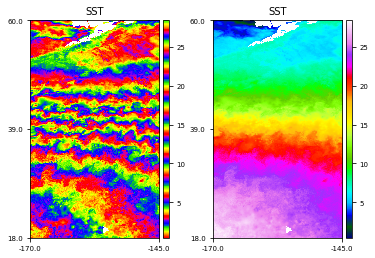

In [5]:
make_plot(sstReg, 121, 'prism', 'SST', None, None)
make_plot(sstReg, 122, 'gist_ncar', 'SST', None, None)

### Convolved Sea Surface Temperature Plot
The conv_for_vis function takes two parameters: an array of data and a kernel size. The kernel size is passed into the Box2DKernel function, which creates a kernel that can be used in the ap_convolve function. The function returns a convolution of the array passed in.
> astropy.convolution.convolve() (ap_convolve) documentation: http://docs.astropy.org/en/stable/api/astropy.convolution.convolve.html
> astropy.convolution.Box2DKernel() documentation: http://docs.astropy.org/en/stable/api/astropy.convolution.Box2DKernel.html

In [6]:
def conv_for_vis(data, size):
    box_2D_kernel = Box2DKernel(size)
    nan=float('nan')
    data=np.ma.filled(data,nan)
    data[ :, 0]=nan
    data[ 0, :]=nan
    data[ :,-1]=nan
    data[-1, :]=nan
    data2=ap_convolve(data, box_2D_kernel)
    conv=data2
    conv=conv[size:-size, size:-size]
    conv=np.ma.masked_invalid(conv)
    return conv

For this project, we used a kernel size of nine. 

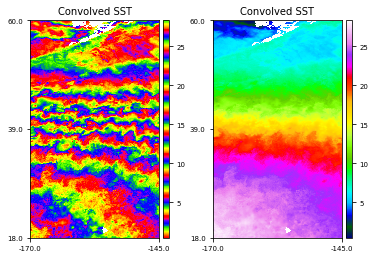

In [7]:
conv = conv_for_vis(sstReg, 9)
make_plot(conv, 121, 'prism', 'Convolved SST', None, None)
make_plot(conv, 122, 'gist_ncar', 'Convolved SST', None, None)

### Difference Plot
The convolved data (conv) is subtracted from the original data (sstReg) to create an array of the difference between the two arrays. The first plot is non-normalized, and therefore the extremes throw off the visual. The second is normalized by +/- 0.1. The second array gives a detailed visual representation of sea surface temperature variation. The greenish/yellow color represents  a difference of 0, meaning that the average of the 81 surrounding points is almost/exactly equal to the temperature at that point. The more colorful regions represent areas of higher temperature variation.

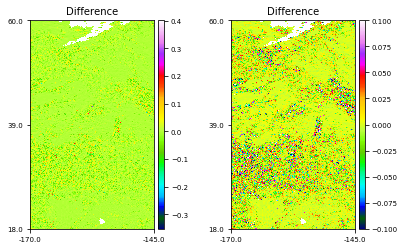

In [8]:
sstReg=sstReg[9:-9, 9:-9]
dif = sstReg - conv
make_plot(dif, 121, 'gist_ncar',  'Difference', None, None)
make_plot(dif, 122, 'gist_ncar',  'Difference', -0.1, 0.1)
plt.subplots_adjust(wspace = 0.5)

___
## Histograms
Histograms are included in the final image so as to help the viewer understand the data quantitatively. The make_hist function's parameters are an array of data and a number for the subplot function. The function prints a histogram and returns nothing.

In [9]:
def make_hist(data, num):
    if num != None:
        ax = plt.subplot(num)
        ax.tick_params(axis='both', labelsize=5)
    phi = data.flatten()
    hist = plt.hist(phi, bins=50)
        
    # sst labels change to phi see if no str works, look at format statments
    dmax = np.nanmax(phi)
    dmin = np.nanmin(phi)
    dmean = np.nanmean(phi)    
    dstd = np.nanstd(phi)
    dskew = stats.mstats.skew(phi, axis=None)
    dkurt = stats.mstats.kurtosis(phi, axis=None)
    plt.xlabel(f'max: {dmax:.3f}\n min: {dmin:.3f}\n mean: {dmean:.3f}\n std: {dstd:.3f}\n skew: {dskew:.3f}\n kurtosis: {dkurt:.3f}', size=7)

A histogram example using the original array (sstReg):

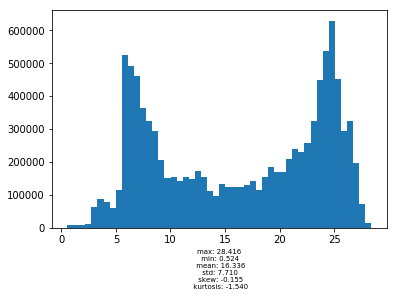

In [10]:
make_hist(sstReg, None)

___
## Final Figure(s)

This loop was used to create plots the data of an entire year, saving each plot into a folder corresponding to its month. The if statement read `if filename[:4] == '2012':` For the purpose of this notebook, only three figures are printed, thus the if statement is altered. The first 8 characters of the filename correspond to the data's date. Therefore, in this case, the researcher can control how many/which plots are printed by manipulating the if statement.

> Title breakdown:
> * filename[:4]: year
> * filename[4:6]: month
> * filename[6:8]: date

Each figure includes the sea surface temperature plot, the convolved plot, and the difference plot, as well as histograms and statistics for each dataset.

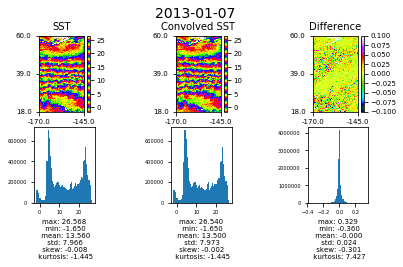

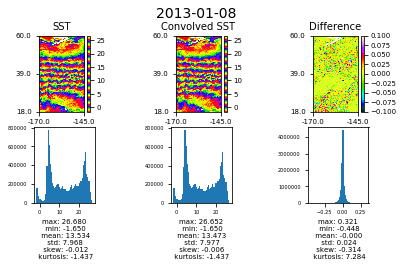

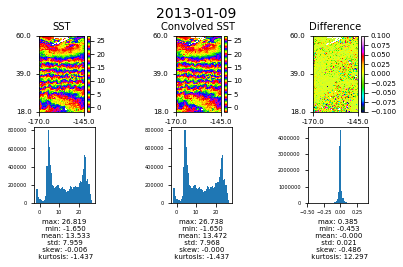

<Figure size 432x288 with 0 Axes>

In [11]:
# Ignore runtime warning
import warnings
warnings.filterwarnings('ignore')

os.chdir('/nfs/cnhlab003/cnh')
for filename in os.listdir('mur-sst'):
        if filename[:8] == '20130109' or filename[:8] == '20130108' or filename[:8] == '20130107':   
            boxsize=9

            # Choose x and y range
            yhi = 15000
            ylo = 10800
            xhi = 3500
            xlo = 1000

            # Create "handle" to access netCDF file
            tFile = netCDF4.Dataset('mur-sst/'+filename)
            extract_data(tFile)
            
            tFile_info=extract_data(tFile)
            sstReg, date=tFile_info[0], tFile_info[1]
            latmin, lonmin=tFile_info[2], tFile_info[3]
            latmax, lonmax=tFile_info[4], tFile_info[5]
            
            # Make sst data plots
            make_plot(sstReg, 231, 'prism', 'SST', None, None)
            make_hist(sstReg, 234)

            # Convolve sst data
            conv = conv_for_vis(sstReg, boxsize)

            # Make convolved data plots
            make_plot(conv, 232, 'prism', 'Convolved SST', None, None)
            make_hist(conv, 235)

            # Find difference between original and convolved data
            sstReg=sstReg[boxsize:-boxsize, boxsize:-boxsize]
            dif = sstReg - conv

            # Difference data plots
            make_plot(dif, 233, 'gist_ncar',  'Difference', -0.1, 0.1)
            dif = dif[np.logical_not(np.isnan(dif))] # Removes nan values from histogram
            make_hist(dif, 236)

            # Format plots
            plt.suptitle(date, fontsize=14)
            plt.subplots_adjust(wspace = 1.25, bottom = 0.3)

            # Save and show fig
            month = calendar.month_name[int(filename[4:6])]
            os.chdir('/home/culberta/public_html/sstconvdif-imgs-2012/'+month)
            plt.savefig(str(date) + '.png', dpi = 200)
            plt.show()
            plt.clf()
            os.chdir('/nfs/cnhlab003/cnh')

___
## Materials and Price of Project
Our cost (not including price of materials already owned): ~\$72    
Our cost (including price of materials already owned): ~\$240  
Lowest cost of all materials: \$118.90
If one has access to a monitor, keyboard, mouse and ethernet cable, the price drops to as low as ~\$75. And if the Raspberry Pi is the sole thing needed to be purchased, the total is \$34.99
*Prices may have changed*  

| Material | What we used | Best price found |
| ---------- | -------------- | ----------------- |
| Raspberry Pi | [\$34.99](https://www.amazon.com/Raspberry-Pi-RASPBERRYPI3-MODB-1GB-Model-Motherboard/dp/B01CD5VC92/ref=sr_1_3?ie=UTF8&qid=1534449603&sr=8-3&keywords=raspberry+pi+3) | Same |
| Monitor | [\$139.98](https://www.amazon.com/Dell-UltraSharp-2408WFP-24-inch-monitor/dp/B001HBA718) | [\$31.99](https://www.amazon.com/Dell-E173FP-Panel-Color-Monitor/dp/B0007LZH7S/ref=sr_1_7?s=pc&ie=UTF8&qid=1534448168&sr=1-7&keywords=monitor&refinements=p_36\%3A-5000) |
| Mouse | [\$13.99](https://www.dell.com/en-us/work/shop/accessories/apd/a6984616?cid=298721&st=&gclid=CjwKCAjwwdTbBRAIEiwAYQf_E0RcoA7Zym0cI_TFprMjAG9rz9rLvm300sjSRnGmbwFrJmhhGyWFyxoCCc8QAvD_BwE&lid=5704670&VEN1=s5peddoRA,101952148149,901q5c14135,c,,A6984616&VEN2=,&dgc=st&dgseg=so&acd=12309152537501410&VEN3=810904535026232866) | [\$5.90](https://www.amazon.com/Verbatim-Optical-Mouse-Accessibility-Compatible/dp/B071KGQP23/ref=sr_1_3?s=electronics&dd=i2tyJxOd7yLXifnSISTJ7w\%2C\%2C&ddc_refnmnt=pfod&ie=UTF8&qid=1534448263&sr=1-3&keywords=mouse&refinements=p_97\%3A11292772011) |
| Keyboard | [\$9.99](https://store.hp.com/us/en/pdp/hp-k1500-keyboard) | [\$8.99](https://www.amazon.com/Rii-Ultra-Slim-Compact-Keyboard-Windows/dp/B077P45VND/ref=sr_1_1?s=electronics&dd=i2tyJxOd7yLXifnSISTJ7w\%2C\%2C&ddc_refnmnt=pfod&ie=UTF8&qid=1534448343&sr=1-1&keywords=keyboard&refinements=p_36\%3A1253503011\%2Cp_97\%3A11292772011) |
| Wifi connection | [\$8.95](https://www.canakit.com/raspberry-pi-wifi.html) | [\$3.40](https://www.amazon.com/Monoprice-Cat6-Ethernet-Patch-Cable/dp/B002RBECAE/ref=sr_1_3?ie=UTF8&qid=1534449455&sr=8-3&keywords=ethernet+cable) |
| Micro SD card | [\$9.66](https://www.amazon.com/Micro-BOYMXU-Memory-Adapter-Update-GRAY/dp/B07FBWGCS2/ref=sr_1_2_sspa?s=pc&rps=1&ie=UTF8&qid=1534448586&sr=1-2-spons&keywords=micro+sd+card&refinements=p_85%3A2470955011&psc=1) | Same |
| Micro SD Reader | [\$7.99](https://www.amazon.com/SmartQ-C307-Portable-MicroSDHC-MicroSDXC/dp/B06ZYXR7DL/ref=sr_1_1_sspa?s=electronics&ie=UTF8&qid=1534448495&sr=1-1-spons&keywords=micro+sd+card+reader&psc=1) | Same |
| Power cord | [\$9.99](https://www.amazon.com/CanaKit-Raspberry-Supply-Adapter-Listed/dp/B00MARDJZ4/ref=pd_sbs_147_3?_encoding=UTF8&pd_rd_i=B00MARDJZ4&pd_rd_r=YPMPWSWMGAAE8K44YX90&pd_rd_w=oa3rR&pd_rd_wg=zkcXu&psc=1&refRID=YPMPWSWMGAAE8K44YX90) | Same |
| HDMI cord | [\$5.99](https://www.amazon.com/AmazonBasics-High-Speed-HDMI-Cable-1-Pack/dp/B014I8SIJY/ref=asc_df_B014I8T0YQ/?tag=hyprod-20&linkCode=df0&hvadid=176633343507&hvpos=1o1&hvnetw=g&hvrand=12392325126929541844&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9002003&hvtargid=pla-195029131275&th=1) | Same |

___
## Summary
There are a few notable conclusions of this project. The first being the resulting figures, which can be used to visually analyze the variability of sea surface temperatures in the northern pacific. This project can also serve as an example of supercomputing in an accessible and affordable fashion. 